In [4]:
%matplotlib inline

# import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('seaborn-colorblind')
# sns.palplot(sns.color_palette("GnBu_d"))

import os
import json
import shap
import pandas as pd

from xgboost import XGBClassifier, plot_importance, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GridSearchCV

# load JS visualization code to notebook
shap.initjs()

random_state = 7

kfold = StratifiedKFold(n_splits=5, random_state=random_state)

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.


In [5]:
def default_exclusion():
    return ['page_id', 
            'page', 
            'category', 
            'user', 
            'label', 
            'content_token_edit_count_avg', 
            'content_token_vs_stop_words']

def generalized_model_exclusion():
    exclusion = default_exclusion()
    exclusion.extend(['page_talk_edits',
                        'tenure',
                        'ns1_edit_dist',
                        'ns2_edit_dist',
                        'ns3_edit_dist',
                        'ns4_edit_dist',
                        'ns5_edit_dist',
                        'ns6_edit_dist',
                        'ns7_edit_dist',
                        'ns8_edit_dist',
                        'ns9_edit_dist',
                        'ns10_edit_dist',
                        'ns11_edit_dist',
                        'ns12_edit_dist',
                        'ns13_edit_dist',
                        'ns14_edit_dist',
                        'ns15_edit_dist',
                        'total_edited_pages'])
    return exclusion

def cross_validation(classifier, x, y, cv):
    print(type(classifier).__name__)
    results = cross_val_score(classifier, x, y, cv=cv)
    
    print(results)
    print('Accuracy: %.3f%%' % (results.mean()))
    print('Precision: %.3f%%' % (cross_val_score(classifier, x, y, scoring='precision', cv=cv).mean())) 
    print('Recall: %.3f%%' % (cross_val_score(classifier, x, y, scoring='recall', cv=cv).mean()))
    print('F1: %.3f%%' % (cross_val_score(classifier, x, y, scoring='f1', cv=cv).mean()))
    print('ROC AUC: %.3f%%' % (cross_val_score(classifier, x, y, scoring='roc_auc', cv=cv).mean()))
    print('\n')

## Data

In [6]:
# train_df = pd.read_csv(os.path.join('data', 'train_filtered.csv'))
train_df = pd.read_csv(os.path.join('data', 'train.csv'))
print(f'train: {train_df.shape}')

# number of smes (label = True)
n_smes = train_df[train_df.label == 1.].shape[0]
# sampling over non-smes (label = False) according to number of smes
unknowns_df = train_df[train_df.label != 1.].sample(n=n_smes, random_state=random_state, axis=0)
# setting up a dataset for training (smes + sampled non-smes)
train_df = train_df[train_df.label == 1.].append(unknowns_df)
# preserving label and information fields
info_df = train_df[['category', 'page_id', 'page', 'user', 'label']]

X = train_df.drop(columns=generalized_model_exclusion(), axis=1)
Y = train_df.label

print ('Total SMEs: {}'.format(len(train_df[train_df.label == 1])))
print ('Total Unknowns: {}'.format(len(train_df[train_df.label == 0])))

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)

train: (14575, 59)
Total SMEs: 625
Total Unknowns: 625


In [205]:
train_df.user.nunique()

860

In [13]:
info_df.to_csv('data/train_labels.csv', index=False)
info_df.head()

,category,page_id,page,user,label
3,Culture,12,Anarchism,Angelicapple,1.0
7,Culture,12,Anarchism,JJARichardson,1.0
9,Culture,12,Anarchism,Kalogeropoulos,1.0
19,Language,25,Autism,Alex.tan,1.0
22,Language,25,Autism,Centerforautism,1.0


In [4]:
with open(os.path.join('data', 'best_params.json'), 'r') as infile:
    best_params = json.load(infile)

print(best_params)

{'colsample_bytree': 0.5, 'learning_rate': 0.09, 'max_depth': 7, 'min_child_weight': 7, 'missing': -999, 'n_estimators': 100, 'nthread': 4, 'objective': 'binary:logistic', 'seed': 7, 'silent': 1, 'subsample': 0.8}


In [5]:
model = XGBClassifier(objective=best_params['objective'], 
                      seed=best_params['seed'], 
                      n_estimators=best_params['n_estimators'],
                      missing=best_params['missing'],
                      colsample_bytree=best_params['colsample_bytree'],
                      learning_rate=best_params['learning_rate'],
                      max_depth=best_params['max_depth'],
                      min_child_weight=0.1,
                      subsample=best_params['subsample']
                     )
cross_validation(classifier=model, x=X_train, y=y_train, cv=kfold)

XGBClassifier
[0.71144279 0.7761194  0.76       0.72864322 0.74371859]
Accuracy: 0.744%
Precision: 0.728%
Recall: 0.775%
F1: 0.750%
ROC AUC: 0.816%




In [152]:
model.fit(X=X_train, y=y_train)
preds = model.predict(X_test)

In [153]:
output = X_test.copy()
output[info_df.columns] = info_df
output['pred'] = preds
print(output.shape)
print(output.columns)

(250, 40)
Index(['page_edits', 'page_edits_ratio', 'edit_period_q1', 'edit_period_q2',
       'edit_period_q3', 'edit_period_q4', 'mean_edit_frequency',
       'mean_edit_size', 'median_edit_size', 'edit_type_a', 'edit_type_b',
       'edit_type_c', 'edit_type_d', 'edit_type_e', 'edit_type_f',
       'edit_type_g', 'edit_type_h', 'edit_type_i', 'edit_type_j',
       'edit_type_k', 'edit_type_l', 'edit_type_m', 'gender', 'ns0_edit_dist',
       'page_edit_dist', 'avg_persistence', 'content_token_count',
       'content_token_vs_token', 'persistence_exists', 'title_similarity',
       'summary_similarity', 'categories_overlap', 'links_overlap',
       'contribution_similarity', 'category', 'page_id', 'page', 'user',
       'label', 'pred'],
      dtype='object')


In [156]:
def eval_class(row):
    if row.label==1 and row.pred==1:
        return 'TP'
    elif row.label==0 and row.pred==1:
        return 'FP'
    elif row.label==0 and row.pred==0:
        return 'TN'
    else:
        return 'FN'

output['class'] = output.apply(lambda row: eval_class(row), axis=1)

print('TP: ',output[output['class'] == 'TP'].shape)
print('FP: ',output[output['class'] == 'FP'].shape)
print('TN: ',output[output['class'] == 'TN'].shape)
print('FN: ',output[output['class'] == 'FN'].shape)

TP:  (105, 41)
FP:  (25, 41)
TN:  (97, 41)
FN:  (23, 41)


The editor's gender	gender
Total number of edits by user in specific article	page_edits
A ratio between total number of edits by user in specific article, and total number of edits in this article	page_edits_ratio
Total number of edit's by user in specific article in the first quarter	edit_period_q1
Total number of edit's by user in specific article in the second quarter	edit_period_q2
Total number of edit's by user in specific article in the third quarter	edit_period_q3
Total number of edit's by user in specific article in the fourth quarter	edit_period_q4
How frequently the user tend to edit Wikipedia articles	mean_edit_interval
Mean edit length of the modified text	mean_edit_size
Total number of words contributed by an editor to specific article	content_token_count
Reference [to external sources]	edit_type_a
Add Substantive New Content	edit_type_b
Add or Change Wiki Markup	edit_type_c
Move or Create New Article	edit_type_d
Delete Substantive Content	edit_type_e
Fix Typo(s) and Grammatical Errors	edit_type_f
Reorganize Existing Text	edit_type_g
Rephrase Existing Text	edit_type_h
Insert Vandalism	edit_type_i
Delete Vandalism	edit_type_j
Hyperlinks [to other Wikipedia pages]	edit_type_k
Miscellaneous	edit_type_l
No consensus	edit_type_m
A parameter used to determine whether edit type exist for specific revision	edit_type_exists
Ratio between meaningful words and non-meaningful (stop words, punctuations)	content_token_vs_token
(ESA) semantic relatedness between article's summary and user contributed text	contribution_similarity
Mean token persistence	avg_persistence
Total number of edits by user in specific article's talk page	page_talk_edits
The difference between the first and the last edit of a user	tenure
Total edited pages	total_edited_pages
Mean of links intersection across top edited articles	links_overlap
Mean of categories intersection across top edited articles	categories_overlap
Mean (ESA) semantic relatedness across top edited articles' titles	title_similarity
Mean (ESA) semantic relatedness across top edited articles' summaries	summary_similarity
Entropy of user edits across all articles	page_edit_dist
The ration between total number of edits in namespace 0, and total number of edits across all namespaces	ns0_edit_dist
The ration between total number of edits in namespace 1, and total number of edits across all namespaces	ns1_edit_dist
The ration between total number of edits in namespace 2, and total number of edits across all namespaces	ns2_edit_dist
The ration between total number of edits in namespace 3, and total number of edits across all namespaces	ns3_edit_dist
The ration between total number of edits in namespace 4, and total number of edits across all namespaces	ns4_edit_dist
The ration between total number of edits in namespace 5, and total number of edits across all namespaces	ns5_edit_dist
The ration between total number of edits in namespace 6, and total number of edits across all namespaces	ns6_edit_dist
The ration between total number of edits in namespace 7, and total number of edits across all namespaces	ns7_edit_dist
The ration between total number of edits in namespace 8, and total number of edits across all namespaces	ns8_edit_dist
The ration between total number of edits in namespace 9, and total number of edits across all namespaces	ns9_edit_dist
The ration between total number of edits in namespace 10, and total number of edits across all namespaces	ns10_edit_dist
The ration between total number of edits in namespace 11, and total number of edits across all namespaces	ns11_edit_dist
The ration between total number of edits in namespace 12, and total number of edits across all namespaces	ns12_edit_dist
The ration between total number of edits in namespace 13, and total number of edits across all namespaces	ns13_edit_dist
The ration between total number of edits in namespace 14, and total number of edits across all namespaces	ns14_edit_dist
The ration between total number of edits in namespace 15, and total number of edits across all namespaces	ns15_edit_dist

In [208]:
def prepare_features_display(df: pd.DataFrame):
    df_copy = df.copy()
    df_copy.rename(inplace=True, columns={
    'page_edits': '# of edits on page',
    'page_edits_ratio': '# of edits on page / total # of edits',
    'edit_period_q1': 'Q1 edit period',
    'edit_period_q2': 'Q2 edit period',
    'edit_period_q3': 'Q3 edit period',
    'edit_period_q4': 'Q4 edit period',
    'mean_edit_frequency': 'Edit frequency',
    'mean_edit_size': 'Mean edit size',
    'median_edit_size': 'Median edit size',
    'edit_type_a': 'Edit type: Reference [to external sources]',
    'edit_type_b': 'Edit type: Add Substantive New Content',
    'edit_type_c': 'Edit type: Add or Change Wiki Markup',
    'edit_type_d': 'Edit type: Move or Create New Article',
    'edit_type_e': 'Edit type: Delete Substantive Content',
    'edit_type_f': 'Edit type: Fix Typo(s) and Grammatical Errors',
    'edit_type_g': 'Edit type: Reorganize Existing Text',
    'edit_type_h': 'Edit type: Rephrase Existing Text',
    'edit_type_i': 'Edit type: Insert Vandalism',
    'edit_type_j': 'Edit type: Delete Vandalism',
    'edit_type_k': 'Edit type: Hyperlinks [to other Wikipedia pages]',
    'edit_type_l': 'Edit type: Miscellaneous',
    'edit_type_m': 'Edit type: No consensus',
    'gender': 'Gender',
    'ns0_edit_dist': '# of edits in namespace 0 / # of edits across all namespaces',
    'page_edit_dist': 'Page edits entropy',
    'avg_persistence': 'Mean edit persistence',
    'content_token_count': '# of meaningful words',
    'content_token_vs_token': 'Ratio of meaningful and non-meaningful words',
    'title_similarity': 'Topic similarity across edited pages',
    'summary_similarity': 'Preview similarity across edited pages',
    'categories_overlap': 'Category similarity across edited pages',
    'links_overlap': 'Link similarity across edited pages',
    'contribution_similarity': 'On page contribution relatedness'})
    return df_copy

In [216]:
X_test_FP = output[output['class']=='FP']
X_test_FP.drop(columns=list(info_df.columns) + ['pred', 'class'], inplace=True)
fp_fd = prepare_features_display(df=X_test_FP)
fp_fd.head()

,# of edits on page,# of edits on page / total # of edits,Q1 edit period,Q2 edit period,Q3 edit period,Q4 edit period,Edit frequency,Mean edit size,Median edit size,Edit type: Reference [to external sources],...,Page edits entropy,Mean edit persistence,# of meaningful words,Ratio of meaningful and non-meaningful words,persistence_exists,Topic similarity across edited pages,Preview similarity across edited pages,Category similarity across edited pages,Link similarity across edited pages,On page contribution relatedness
10272,0.003238,0.000908,0.0,0.0,1.0,0.0,0.021162,0.034956,0.035258,0.0,...,0.488312,0.044638,0.000058,0.006541,1.0,0.000000,0.000000,0.014866,0.005398,0.0
5115,0.000648,0.011364,0.0,1.0,0.0,0.0,0.000000,0.002132,0.002132,0.0,...,0.459719,0.386384,0.000000,0.000000,1.0,0.000000,0.000045,0.000000,0.003774,0.0
233,0.003238,0.000432,0.6,0.4,0.0,0.0,0.068902,0.018560,0.008838,0.0,...,0.139420,0.028078,0.000232,0.008140,1.0,0.001279,0.003502,0.010916,0.016613,0.0
2181,0.000648,0.000206,0.0,1.0,0.0,0.0,0.000000,0.018122,0.018122,0.0,...,0.316314,0.000695,0.000012,0.004579,1.0,0.000000,0.000062,0.022427,0.024825,0.0
195,0.000648,0.000086,0.0,1.0,0.0,0.0,0.000000,0.059927,0.059927,0.0,...,0.340924,0.003796,0.000000,0.000000,1.0,0.000000,0.000051,0.031021,0.012291,0.0


In [217]:
X_test_TP = output[output['class']=='TP']
X_test_TP.drop(columns=list(info_df.columns) + ['pred', 'class'], inplace=True)
tp_fd = prepare_features_display(df=X_test_TP)
tp_fd.head()

,# of edits on page,# of edits on page / total # of edits,Q1 edit period,Q2 edit period,Q3 edit period,Q4 edit period,Edit frequency,Mean edit size,Median edit size,Edit type: Reference [to external sources],...,Page edits entropy,Mean edit persistence,# of meaningful words,Ratio of meaningful and non-meaningful words,persistence_exists,Topic similarity across edited pages,Preview similarity across edited pages,Category similarity across edited pages,Link similarity across edited pages,On page contribution relatedness
9350,0.000648,0.000445,0.000000,1.000000,0.000000,0.000000,0.000000,0.006361,0.006361,0.000000,...,0.441646,0.000000,0.000000,0.000000,1.0,0.000376,0.000039,0.049882,0.019366,0.00000
3092,0.033031,0.044658,0.235294,0.450980,0.235294,0.078431,0.032900,0.021841,0.021841,0.019608,...,0.530023,0.017622,0.001038,0.003096,1.0,0.000118,0.000834,0.045263,0.084544,0.00000
4769,0.005181,0.012346,0.500000,0.375000,0.125000,0.000000,0.101264,0.005004,0.004115,0.125000,...,0.674218,0.097982,0.001107,0.002753,1.0,0.000000,0.000169,0.054768,0.011001,0.00000
7586,0.000648,0.000399,0.000000,0.000000,1.000000,0.000000,0.000000,0.027004,0.027004,0.000000,...,0.271821,0.010979,0.000123,0.002339,1.0,0.000000,0.000043,0.012374,0.005718,0.00000
5260,0.004534,0.014170,0.428571,0.571429,0.000000,0.000000,0.056079,0.004899,0.004559,0.000000,...,0.625299,0.095036,0.000051,0.004740,1.0,0.028639,0.000205,0.000000,0.029932,0.00048


In [218]:
print(tp_fd['# of edits on page'].mean())
print(fp_fd['# of edits on page'].mean())

0.01037503084135209
0.0019430051813471504


In [161]:
import warnings

explainer = shap.TreeExplainer(model)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

features = X_test_FP
features_display = features_display.columns

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(features)
    shap_interaction_values = explainer.shap_interaction_values(features)
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


Explainer expected value: -0.038657402070384705


In [74]:
# shap.decision_plot(expected_value, shap_values, features_display)

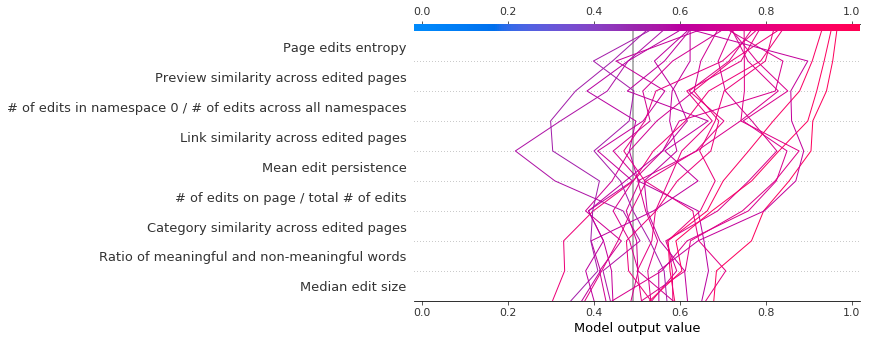

In [171]:
shap.decision_plot(expected_value, shap_values, features_display, link='logit', feature_display_range=slice(-1,-10,-1))

In [178]:
# # y_pred = (shap_values.sum() + expected_value) > 0
# # misclassified = y_pred != y_test.head(50)
# y_pred = (shap_values.sum() + expected_value) < 0
# misclassified = y_pred == y_test.tail(50)
# shap.decision_plot(expected_value, shap_values, features_display, link='logit', highlight=misclassified)

In [172]:
output[output['class']=='FP']

,page_edits,page_edits_ratio,edit_period_q1,edit_period_q2,edit_period_q3,edit_period_q4,mean_edit_frequency,mean_edit_size,median_edit_size,edit_type_a,...,categories_overlap,links_overlap,contribution_similarity,category,page_id,page,user,label,pred,class
10272,0.003238,0.000908,0.000000,0.000000,1.000000,0.000000,2.116161e-02,0.034956,0.035258,0.0000,...,0.014866,0.005398,0.000000,Life,210472,Pancake,Ks0stm,0.0,1.0,FP
5115,0.000648,0.011364,0.000000,1.000000,0.000000,0.000000,0.000000e+00,0.002132,0.002132,0.0000,...,0.000000,0.003774,0.000000,Politics,1111,Politics of American Samoa,Lord Voldemort,0.0,1.0,FP
233,0.003238,0.000432,0.600000,0.400000,0.000000,0.000000,6.890206e-02,0.018560,0.008838,0.0000,...,0.010916,0.016613,0.000000,Society,339,Ayn Rand,Bedevere~enwiki,0.0,1.0,FP
2181,0.000648,0.000206,0.000000,1.000000,0.000000,0.000000,0.000000e+00,0.018122,0.018122,0.0000,...,0.022427,0.024825,0.000000,Science,740,Allah,Glacious,0.0,1.0,FP
195,0.000648,0.000086,0.000000,1.000000,0.000000,0.000000,0.000000e+00,0.059927,0.059927,0.0000,...,0.031021,0.012291,0.000000,Society,339,Ayn Rand,Ash Loomis,0.0,1.0,FP
6286,0.000648,0.000690,0.000000,1.000000,0.000000,0.000000,0.000000e+00,0.006886,0.006886,0.0000,...,0.038027,0.011734,0.000000,Geography,1797,Acre,Leuko,0.0,1.0,FP
4744,0.000648,0.001543,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.003979,0.003979,0.0000,...,0.087477,0.017330,0.000000,Society,930,Alvin Toffler,MementoVivere,0.0,1.0,FP
1023,0.000648,0.000086,0.000000,1.000000,0.000000,0.000000,0.000000e+00,0.079671,0.079671,1.0000,...,0.035006,0.012382,0.000000,Society,339,Ayn Rand,Olegkagan,0.0,1.0,FP
6105,0.002591,0.001388,0.000000,0.000000,0.000000,1.000000,1.460938e-02,0.075205,0.074462,0.0000,...,0.023405,0.004587,0.000000,Humanities,1625,Aleksandr Solzhenitsyn,SkoraPobeda,0.0,1.0,FP
12780,0.000648,0.000465,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.015682,0.015682,0.0000,...,0.038942,0.011253,0.000000,Chronology,3171735,Steven E. Jones,Trovatore,0.0,1.0,FP


In [184]:
print('''
Page ID: 210472
Page Title: Pancake
User: Ks0stm

This user is a member of the English Wikipedia Arbitration Committee. (2017-2018)
This user is an administrator on the English Wikipedia.
This user is a global renamer.
This user is in university.
''')

shap.force_plot(expected_value, shap_values[0,:], X_test_FP.iloc[0,:], matplotlib=False)


Page ID: 210472
Page Title: Pancake
User: Ks0stm

This user is a member of the English Wikipedia Arbitration Committee. (2017-2018)
This user is an administrator on the English Wikipedia.
This user is a global renamer.
This user is in university.



In [185]:
print('''
Page ID: 1111
Page Title: Politics of American Samoa
User: Lord Voldemort

I am an Administrator on the English Wikipedia, and a former Administrator on the English Wikibooks.
''')

shap.force_plot(expected_value, shap_values[1,:], X_test_FP.iloc[1,:], matplotlib=False)


Page ID: 1111
Page Title: Politics of American Samoa
User: Lord Voldemort

I am an Administrator on the English Wikipedia, and a former Administrator on the English Wikibooks.



In [186]:
print('''
Page ID: 339
Page Title: Ayn Rand
User: Bedevere~enwiki

None.
''')

shap.force_plot(expected_value, shap_values[2,:], X_test_FP.iloc[2,:], matplotlib=False)


Page ID: 339
Page Title: Ayn Rand
User: Bedevere~enwiki

None.



In [187]:
print('''
Page ID: 740
Page Title: Allah
User: Glacious

None.
''')

shap.force_plot(expected_value, shap_values[3,:], X_test_FP.iloc[3,:], matplotlib=False)


Page ID: 740
Page Title: Allah
User: Glacious

None.



-----------------------------------






















In [189]:
train_explainer = shap.TreeExplainer(model)
train_expected_value = train_explainer.expected_value
train_shap_values = explainer.shap_values(X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [ ]:
# shap.decision_plot(explainer.expected_value, shap_values[misclassified], features_display[misclassified], link='logit', highlight=0)

In [173]:
# for i in range(0, 10, 1):
# #     i=10
#     print(f'Label: {True if y_train.iloc[i] > 0 else False}' )
#     # visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
#     shap.force_plot(explainer.expected_value, shap_values[i,:], X_train.iloc[i,:], matplotlib=True)

In [174]:
# visualize the training set predictions
# shap.force_plot(explainer.expected_value, shap_values, X_train, figsize=(20, 20), matplotlib=False)

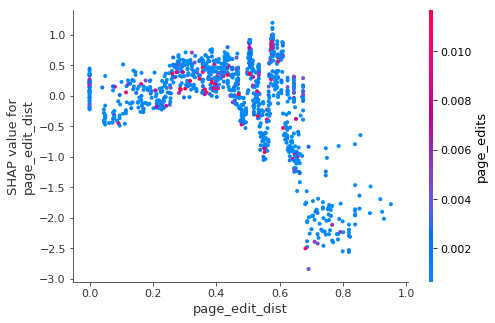

In [201]:
# create a dependence plot to show the effect of a single feature across the whole dataset
# shap.dependence_plot("avg_persistence", shap_values, X_train)
shap.dependence_plot("page_edit_dist", train_shap_values, X_train, interaction_index='page_edits')

In [198]:
X_train.corr()

,page_edits,page_edits_ratio,edit_period_q1,edit_period_q2,edit_period_q3,edit_period_q4,mean_edit_frequency,mean_edit_size,median_edit_size,edit_type_a,...,page_edit_dist,avg_persistence,content_token_count,content_token_vs_token,persistence_exists,title_similarity,summary_similarity,categories_overlap,links_overlap,contribution_similarity
page_edits,1.000000,0.389816,-0.050747,-0.005088,0.007409,0.064368,-0.001900,0.163541,0.162369,-0.003789,...,0.023638,-0.033699,0.888427,0.016556,NaN,0.012348,0.013848,0.215815,0.235934,-0.558202
page_edits_ratio,0.389816,1.000000,0.078964,-0.070007,-0.029190,0.043987,0.046283,-0.120109,-0.118546,-0.006489,...,0.030190,0.372774,0.298746,0.022071,NaN,-0.080173,-0.076713,-0.014441,0.092903,-0.219657
edit_period_q1,-0.050747,0.078964,1.000000,-0.442169,-0.312206,-0.207382,-0.025964,-0.352156,-0.354550,0.008952,...,0.064071,0.193199,-0.027030,0.084408,NaN,-0.044030,-0.043418,-0.048689,-0.025106,0.045062
edit_period_q2,-0.005088,-0.070007,-0.442169,1.000000,-0.485642,-0.322866,-0.047682,-0.065348,-0.064955,-0.024486,...,-0.060309,-0.084597,-0.009417,-0.053056,NaN,0.022694,0.022263,0.051211,-0.021664,0.053840
edit_period_q3,0.007409,-0.029190,-0.312206,-0.485642,1.000000,-0.171954,-0.014865,0.215969,0.215892,0.043634,...,-0.049180,-0.010959,0.012251,0.027565,NaN,0.048932,0.050068,-0.020837,0.030125,-0.049617
edit_period_q4,0.064368,0.043987,-0.207382,-0.322866,-0.171954,1.000000,0.127561,0.273998,0.276623,-0.031924,...,0.075076,-0.107095,0.033606,-0.064967,NaN,-0.042727,-0.044375,0.012153,0.026239,-0.076179
mean_edit_frequency,-0.001900,0.046283,-0.025964,-0.047682,-0.014865,0.127561,1.000000,0.027887,0.030881,-0.026536,...,0.075495,0.005634,-0.010169,0.001542,NaN,-0.019586,-0.022098,-0.016119,0.014953,0.001964
mean_edit_size,0.163541,-0.120109,-0.352156,-0.065348,0.215969,0.273998,0.027887,1.000000,0.997422,-0.062871,...,-0.059455,-0.285914,0.144953,-0.006619,NaN,0.081602,0.082726,0.197347,0.055447,-0.116328
median_edit_size,0.162369,-0.118546,-0.354550,-0.064955,0.215892,0.276623,0.030881,0.997422,1.000000,-0.062799,...,-0.059622,-0.284602,0.141998,-0.007816,NaN,0.081273,0.082426,0.195501,0.056131,-0.118847
edit_type_a,-0.003789,-0.006489,0.008952,-0.024486,0.043634,-0.031924,-0.026536,-0.062871,-0.062799,1.000000,...,-0.117837,-0.052018,-0.002576,0.001318,NaN,0.016610,0.017784,-0.011530,0.074047,0.007620


In [197]:
from scipy import stats

# stats.pearsonr(x=X_train['page_edit_dist'], y=X_train['mean_edit_size'])
# stats.chisquare(X_train['page_edit_dist'], f_exp=X_train['mean_edit_size'], axis=1)
# k2, p = stats.normaltest(X_train['page_edit_dist'])

# alpha = 1e-3
# print("p = {:g}".format(p))

# if p < alpha:  # null hypothesis: x comes from a normal distribution
#     print("The null hypothesis can be rejected")
# else:
#     print("The null hypothesis cannot be rejected")

divide by zero encountered in true_divide


AxisError: axis 1 is out of bounds for array of dimension 1

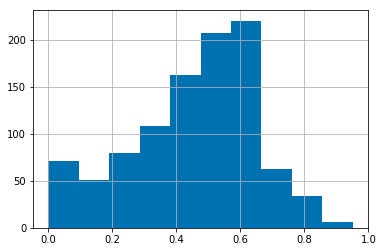

In [196]:
X_train['page_edit_dist'].hist()

In [176]:
# shap.summary_plot(shap_values, X_train, plot_size=(20, 10))

In [177]:
# X_train.corr()

In [36]:
output.to_csv(path_or_buf=r'data/test_strategy3_results.csv', index=False)

<html>
<head>
    <h1>ACM-TSC (True=488/False=497)</h1>
    <h2>Training strategy - random sampling negative examples by positive examples' articles</h2>
</head>
<table align='left' style="font-size:150%;">
<tr><th>Algorithm</th><th>Precision</th><th>Recall</th><th>F1</th><th>ROC (AUC)</th></tr>
<!--     <tr><td>KNN</td><td>0.601</td><td>0.617</td><td>0.608</td><td>0.641</td></tr>
    <tr><td>SVM</td><td>0.589</td><td>0.866</td><td>0.700</td><td>0.646</td></tr>
    <tr><td>RF</td><td>0.736</td><td>0.769</td><td>0.750</td><td>0.818</td></tr>
    <tr><td>GB</td><td>0.741</td><td>0.769</td><td>0.753</td><td>0.830</td></tr> -->
    <tr><td>XGB</td><td>0.737</td><td>0.772</td><td>0.752</td><td>0.832</td></tr>
</table> 
</html>

<html>
<head>
    <h1>ACM-TSC (True=625/False=625)</h1>
    <h2>Training strategy - random sampling negative examples</h2>
</head>
<table align='left' style="font-size:150%;">
<tr><th>Algorithm</th><th>Precision</th><th>Recall</th><th>F1</th><th>ROC (AUC)</th></tr>
<!--     <tr><td>KNN</td><td>0.601</td><td>0.617</td><td>0.608</td><td>0.641</td></tr>
    <tr><td>SVM</td><td>0.589</td><td>0.866</td><td>0.700</td><td>0.646</td></tr>
    <tr><td>RF</td><td>0.736</td><td>0.769</td><td>0.750</td><td>0.818</td></tr>
    <tr><td>GB</td><td>0.741</td><td>0.769</td><td>0.753</td><td>0.830</td></tr> -->
    <tr><td>XGB</td><td>0.728</td><td>0.775</td><td>0.750</td><td>0.816</td></tr>
</table> 
</html>

<html>
<head>
    <h1>ACM-TSC (True=625/False=625)</h1>
    <h2>Training strategy - random sampling negative examples (filtered-out non-smes with expertise terms)</h2>
</head>
<table align='left' style="font-size:150%;">
<tr><th>Algorithm</th><th>Precision</th><th>Recall</th><th>F1</th><th>ROC (AUC)</th></tr>
<!--     <tr><td>KNN</td><td>0.601</td><td>0.617</td><td>0.608</td><td>0.641</td></tr>
    <tr><td>SVM</td><td>0.589</td><td>0.866</td><td>0.700</td><td>0.646</td></tr>
    <tr><td>RF</td><td>0.736</td><td>0.769</td><td>0.750</td><td>0.818</td></tr>
    <tr><td>GB</td><td>0.741</td><td>0.769</td><td>0.753</td><td>0.830</td></tr> -->
    <tr><td>XGB</td><td>0.752</td><td>0.805</td><td>0.778</td><td>0.852</td></tr>
</table> 
</html>